<a href="https://colab.research.google.com/github/Bhanureddy48/Research-Methods-2/blob/main/ResearchMethods_Assignment2_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# Data handling and visualization libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# String module for punctuation handling
import string
# Scikit-learn for splitting data into train and evaluation sets
from sklearn.model_selection import train_test_split
# Load T5 tokenizer and model for English-to-French translation
from transformers import T5Tokenizer, T5ForConditionalGeneration
# Hugging Face Datasets library for managing datasets
from datasets import Dataset
# Data collator for dynamic padding during training
from transformers import DataCollatorForSeq2Seq
# Install or upgrade Hugging Face Transformers library
!pip install -U transformers --quiet
!pip install --upgrade transformers --quiet
!pip install evaluate --quiet
# Install necessary metric dependencies for evaluate
!pip install sacrebleu rouge-score nltk --quiet
# Training configuration and training utilities from Transformers
from transformers import TrainingArguments, Trainer
# PyTorch for model input and device management
import torch
# tqdm for progress bars during generation
from tqdm import tqdm
# Hugging Face Evaluate library for BLEU, ROUGE, METEOR, chrF++ metrics
import evaluate

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.3 MB/s eta 0:00:00


In [3]:
# Define the URL to the English-French translation dataset
eng_to_fr_csv_url = "https://raw.githubusercontent.com/Bhanureddy48/Research-Methods-2/refs/heads/main/eng_-french.csv"
# Load only the first 20,000 rows from the dataset
eng_french_df = pd.read_csv(eng_to_fr_csv_url, nrows=20000)
# Rename columns for clarity
eng_french_df.columns = ["english_text", "french_text"]
# Display the first 5 English-French sentence pairs
print("Selected Set of English-French sentence pairs :")
print(eng_french_df.head())

Selected Set of English-French sentence pairs :
  english_text french_text
0          Hi.      Salut!
1         Run!     Cours !
2         Run!    Courez !
3         Who?       Qui ?
4         Wow!  Ça alors !


In [4]:
# Display basic information about the dataset
eng_french_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   english_text  20000 non-null  object
 1   french_text   20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [5]:
# Show basic statistics for the English and French text columns
print(eng_french_df.describe(include="object"))

             english_text     french_text
count               20000           20000
unique              12291           18222
top     You're very wise.  C'est bizarre.
freq                   18               9


In [6]:
# Check for missing (null) values in each column
print(eng_french_df.isnull().sum())

english_text    0
french_text     0
dtype: int64


In [7]:
# Check how many duplicate sentence pairs exist in the dataset
Eng_Fre_DupCnt = eng_french_df.duplicated().sum()
print(f"Number of duplicate rows: {Eng_Fre_DupCnt}")

Number of duplicate rows: 0


In [8]:
# Add sentence length columns (number of words) to the DataFrame
eng_french_df["english_length"] = eng_french_df["english_text"].apply(lambda x: len(x.split()))
eng_french_df["french_length"] = eng_french_df["french_text"].apply(lambda x: len(x.split()))
# Display basic statistics about sentence lengths
print("Sentence length statistics (word count):")
print(eng_french_df[["english_length", "french_length"]].describe())

Sentence length statistics (word count):
       english_length  french_length
count    20000.000000   20000.000000
mean         3.188550       3.808750
std          0.765721       1.202683
min          1.000000       1.000000
25%          3.000000       3.000000
50%          3.000000       4.000000
75%          4.000000       4.000000
max          5.000000      12.000000


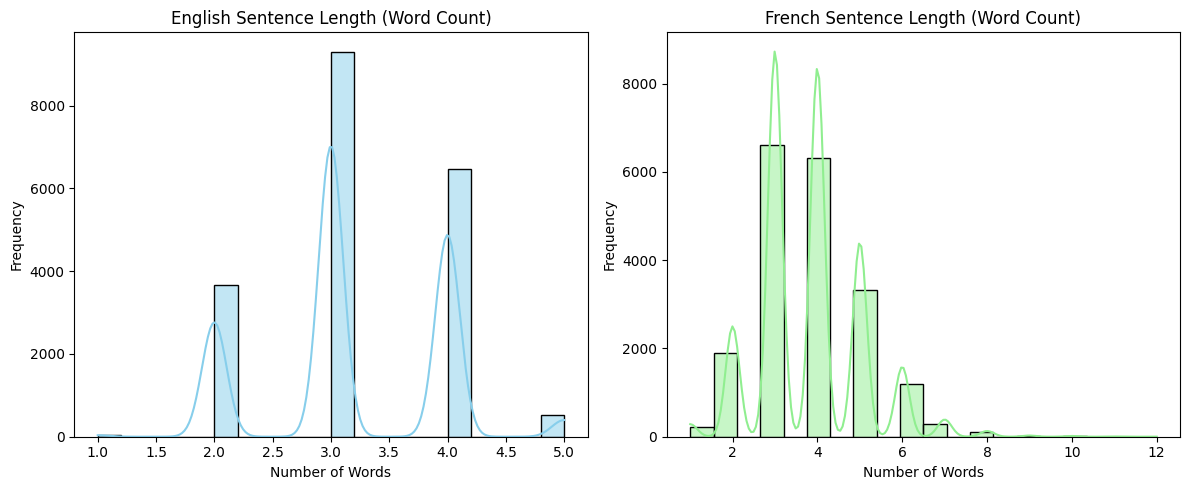

In [9]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# English sentence length distribution with density line
sns.histplot(eng_french_df["english_length"], bins=20, kde=True, ax=axes[0], color="skyblue", edgecolor="black")
axes[0].set_title("English Sentence Length (Word Count)")
axes[0].set_xlabel("Number of Words")
axes[0].set_ylabel("Frequency")
axes[0].grid(False)
# French sentence length distribution with density line
sns.histplot(eng_french_df["french_length"], bins=20, kde=True, ax=axes[1], color="lightgreen", edgecolor="black")
axes[1].set_title("French Sentence Length (Word Count)")
axes[1].set_xlabel("Number of Words")
axes[1].set_ylabel("Frequency")
axes[1].grid(False)
# Improve spacing between plots
plt.tight_layout()
plt.show()

In [10]:
def clean_translation_pairs_dataframe(translation_df, min_char_count=2, max_word_limit=30, strip_punctuation=False):
    """
    This function cleans and preprocesses a DataFrame containing English-to-French
    sentence pairs. It standardizes the text by converting all characters to
    lowercase, trimming leading and trailing whitespace, and optionally removing
    punctuation. Sentence pairs that are too short or too long based on character
    count or word count thresholds are filtered out. The cleaned English and French
    sentences, along with their respective word counts, are stored in new columns.
    The final cleaned DataFrame is returned for use in modeling or further analysis.

    Parameters:
        translation_df (pd.DataFrame): The input DataFrame containing
            'english_text' and 'french_text' columns.
        min_char_count (int): Minimum number of characters required for both
            English and French sentences.
        max_word_limit (int): Maximum number of words allowed in each sentence.
        strip_punctuation (bool): If True, removes punctuation from both English
            and French text.

    Returns:
        pd.DataFrame: A cleaned DataFrame with the following columns:
            - 'english_text', 'french_text' (original sentences),
            - 'english_cleaned', 'french_cleaned' (preprocessed text),
            - 'english_sentence_length', 'french_sentence_length' (word counts).
    """
    # Work on a copy to avoid changing the original DataFrame
    cleaned_translation_df = translation_df.copy()
    # Convert sentences to lowercase and strip whitespace
    cleaned_translation_df["english_cleaned"] = cleaned_translation_df["english_text"].str.lower().str.strip()
    cleaned_translation_df["french_cleaned"] = cleaned_translation_df["french_text"].str.lower().str.strip()
    # remove punctuation from sentences
    if strip_punctuation:
        remove_punct_func = lambda txt: txt.translate(str.maketrans('', '', string.punctuation))
        cleaned_translation_df["english_cleaned"] = cleaned_translation_df["english_cleaned"].apply(remove_punct_func)
        cleaned_translation_df["french_cleaned"] = cleaned_translation_df["french_cleaned"].apply(remove_punct_func)
    # Filter out sentences that are shorter than the minimum character requirement
    cleaned_translation_df = cleaned_translation_df[
        (cleaned_translation_df["english_cleaned"].str.len() >= min_char_count) &
        (cleaned_translation_df["french_cleaned"].str.len() >= min_char_count)].reset_index(drop=True)
    # Calculate word counts for both English and French sentences
    cleaned_translation_df["english_sentence_length"] = cleaned_translation_df["english_cleaned"].apply(lambda x: len(x.split()))
    cleaned_translation_df["french_sentence_length"] = cleaned_translation_df["french_cleaned"].apply(lambda x: len(x.split()))
    # Filter out sentences that exceed the maximum word count
    cleaned_translation_df = cleaned_translation_df[
        (cleaned_translation_df["english_sentence_length"] <= max_word_limit) &
        (cleaned_translation_df["french_sentence_length"] <= max_word_limit)
    ].reset_index(drop=True)
    return cleaned_translation_df

In [11]:
# Apply the translation cleaning function to the existing English-French DataFrame
cleaned_translation_df = clean_translation_pairs_dataframe(eng_french_df, strip_punctuation=True)
# Display original and cleaned sentence pairs
print(cleaned_translation_df[["english_text", "english_cleaned", "french_text", "french_cleaned"]].head())

  english_text english_cleaned french_text french_cleaned
0          Hi.              hi      Salut!          salut
1         Run!             run     Cours !         cours 
2         Run!             run    Courez !        courez 
3         Who?             who       Qui ?           qui 
4         Wow!             wow  Ça alors !      ça alors 


In [12]:
# Split cleaned English-French sentence pairs into training and evaluation sets (90% train, 10% eval)
train_translation_df, eval_translation_df = train_test_split(
    cleaned_translation_df[["english_cleaned", "french_cleaned"]],
    test_size=0.2,random_state=99999)
# Reset index for both training and evaluation DataFrames
train_translation_df = train_translation_df.reset_index(drop=True)
eval_translation_df = eval_translation_df.reset_index(drop=True)

In [13]:
# Load the pretrained T5 tokenizer and model for English-to-French translation
translation_tokenizer = T5Tokenizer.from_pretrained("t5-small")
translation_model = T5ForConditionalGeneration.from_pretrained("t5-small")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [14]:
# Convert training and evaluation DataFrames to Hugging Face Datasets
train_hf_dataset = Dataset.from_pandas(train_translation_df)
eval_hf_dataset = Dataset.from_pandas(eval_translation_df)
def tokenize_translation_pair(example):
    """
    Tokenizes a single English-to-French sentence pair for input into a T5 model.
    It prepends the translation prefix required by the model to the English input,
    tokenizes both English and French sentences, and aligns them as input and labels.

    Parameters:
        example (dict): A dictionary containing 'english_cleaned' and 'french_cleaned' keys.

    Returns:
        dict: A dictionary with tokenized input IDs, attention masks, and labels for training.
    """
    # Add the translation prefix expected by the T5 model
    source_text = "translate English to French: " + example["english_cleaned"]
    target_text = example["french_cleaned"]
    # Tokenize the source (English) sentence
    model_inputs = translation_tokenizer(
        source_text,max_length=128,
        padding="max_length",truncation=True)
    # Tokenize the target (French) sentence as the label
    with translation_tokenizer.as_target_tokenizer():
        label_tokens = translation_tokenizer(
            target_text,max_length=128,
            padding="max_length",truncation=True
        )
    # Assign tokenized labels to the model inputs
    model_inputs["labels"] = label_tokens["input_ids"]
    return model_inputs

In [15]:
# Tokenize the training and evaluation datasets using the custom tokenization function
train_tokenized_dataset = train_hf_dataset.map(tokenize_translation_pair, batched=False)
eval_tokenized_dataset = eval_hf_dataset.map(tokenize_translation_pair, batched=False)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [16]:
# Data collator to dynamically pad inputs and labels for the translation task
translation_data_collator = DataCollatorForSeq2Seq(
    tokenizer=translation_tokenizer,model=translation_model)

In [17]:
# Define training configuration for English-to-French translation using T5
translation_training_args = TrainingArguments(
    output_dir="./t5_translation_eng_to_fr_results",
    do_train=True,do_eval=True,per_device_train_batch_size=8,
    per_device_eval_batch_size=8,learning_rate=3e-4,
    num_train_epochs=3,weight_decay=0.01,
    logging_dir="./t5_translation_logs", logging_steps=50,
    save_total_limit=2, report_to="none")

In [18]:
# Initialize the Trainer for English-to-French translation fine-tuning
translation_trainer = Trainer(
    model=translation_model,
    args=translation_training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=eval_tokenized_dataset,
    tokenizer=translation_tokenizer,         # Tokenizer used during training
    data_collator=translation_data_collator  # Handles dynamic padding
)

/tmp/ipython-input-18-3106532782.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  translation_trainer = Trainer(


In [19]:
# Start training the translation model
translation_train_output = translation_trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
50,1.447400
100,0.126600
150,0.100800
200,0.097100
250,0.091500
300,0.086500
350,0.083300
400,0.080500
450,0.082000
500,0.084800


In [35]:
# Randomly select 200 samples from the evaluation set
translation_eval_df = eval_translation_df.sample(n=500, random_state=9999).reset_index(drop=True)
# Create task-formatted input strings for translation
eng_french_input_texts = [ "translate English to French: " + text
    for text in translation_eval_df["english_cleaned"].tolist()]
# Extract the ground truth French references
french_reference_texts = translation_eval_df["french_cleaned"].tolist()
# Tokenize the input prompts for model processing
eng_french_tokenized_inputs = translation_tokenizer(
    eng_french_input_texts,return_tensors="pt",
    padding=True,truncation=True,
    max_length=128).to(translation_model.device)
# Generate predictions from the translation model
with torch.no_grad():
    eng_french_generated_ids = translation_model.generate(
        input_ids=eng_french_tokenized_inputs["input_ids"],
        attention_mask=eng_french_tokenized_inputs["attention_mask"],
        max_length=128,num_beams=4)
# Decode generated token IDs into actual French sentences
french_predicted_texts = translation_tokenizer.batch_decode(eng_french_generated_ids,
    skip_special_tokens=True)
# Load evaluation metrics
eng_french_bleu_metric = evaluate.load("sacrebleu")
eng_french_rouge_metric = evaluate.load("rouge")
eng_french_chrf_metric = evaluate.load("chrf")
eng_french_meteor_metric = evaluate.load("meteor")
# Compute scores by comparing predicted and reference translations
eng_french_bleu_score = eng_french_bleu_metric.compute(predictions=french_predicted_texts,
    references=[[ref] for ref in french_reference_texts])["score"]
eng_french_rouge_score = eng_french_rouge_metric.compute(predictions=french_predicted_texts,
    references=french_reference_texts)["rougeL"]
eng_french_chrf_score = eng_french_chrf_metric.compute(predictions=french_predicted_texts,
    references=french_reference_texts)["score"]
eng_french_meteor_score = eng_french_meteor_metric.compute(predictions=french_predicted_texts,
                                  references=french_reference_texts)["meteor"]
# Pack evaluation results into a dictionary
eng_french_translation_scores = {
    "BLEU": eng_french_bleu_score,
    "ROUGE-L": eng_french_rouge_score,
    "chrF++": eng_french_chrf_score,
    "METEOR": eng_french_meteor_score
}
# Print formatted evaluation results
print("\nEvaluation on Sample Examples:")
for metric_name, score in eng_french_translation_scores.items():
    print(f"{metric_name}: {score:.2f}")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Evaluation on Sample Examples:
BLEU: 36.08
ROUGE-L: 0.59
chrF++: 57.24
METEOR: 0.52


In [36]:
# Create a DataFrame to compare input, reference, and predicted translations
sample_translation_output_df = pd.DataFrame({
    "English_Input": eng_french_input_texts[:50],
    "French_Reference": french_reference_texts[:50],
    "French_Predicted": french_predicted_texts[:50]
})
# Ensure full text is visible in each cell
pd.set_option('display.max_colwidth', None)
# Display the top 20 comparison results
sample_translation_output_df.head(50)

,English_Input,French_Reference,French_Predicted
0,translate English to French: tell me about it,vous parlez,ditesmoi le sujet
1,translate English to French: i feel dizzy,je me sens drôle,je me sens étourdi
2,translate English to French: youve found it,tu las trouvée,tu l’avez trouvé
3,translate English to French: she is a nurse,elle est infirmière,elle est infirmière
4,translate English to French: i felt cheated,je me sentis trompée,je me suis sentie coupée de trompée
5,translate English to French: i made two,jen ai confectionné deux,jai fait deux
6,translate English to French: he liked that,il aima cela,il a apprécié ça
7,translate English to French: i hate this job,je déteste ce boulot,je déteste ce boulot
8,translate English to French: i bathe every day,je prends un bain tous les jours,je me bavars tous les jours
9,translate English to French: youre creepy,vous êtes sinistres,vous êtes creepy
